In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import functools
from scipy import integrate
import networkx as nx

In [3]:
import os
import math
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

# 1) Generate Random SBM Graphon

In [31]:
def generate_proba_matrix(
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float]
) -> np.ndarray:
    n_groups = np.random.randint(2, max_groups + 1)
    p_intra = np.random.uniform(range_p_intra[0], range_p_intra[1], size=n_groups)
    p = np.random.uniform(range_p_inter[0], range_p_inter[1], size=[n_groups, n_groups])
    np.fill_diagonal(p, p_intra)
    return np.triu(p) + np.triu(p, 1).T

In [32]:
def generate_n_nodes(
    n_groups: int,
    range_n_nodes: List[int]
) -> np.ndarray:
    return np.random.randint(range_n_nodes[0], range_n_nodes[1], n_groups)

In [33]:
def get_graphon_val(
    x: float,
    y: float,
    p: np.ndarray,
    n: np.ndarray
) -> np.ndarray:
    n_nodes = np.sum(n)
    n_nodes_cum = np.cumsum(n)
    
    n_x, n_y = x * n_nodes, y * n_nodes
    i_x, i_y = 0, 0
    while n_x > n_nodes_cum[i_x]:
        i_x += 1
    while n_y > n_nodes_cum[i_y]:
        i_y += 1
    return p[i_x, i_y]

get_graphon = np.vectorize(get_graphon_val, excluded=(2, 3))

In [34]:
def sample_sbm_graphon(
    res: int,
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float],
    range_n_nodes: List[int]
) -> np.ndarray:
    X, Y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    p = generate_proba_matrix(max_groups, range_p_intra, range_p_inter)
    n = generate_n_nodes(p.shape[0], range_n_nodes)
    return get_graphon(X, Y, p, n)

In [35]:
def get_adj(
    n_nodes: int,
    graphon: np.ndarray,
    sort: bool=True,
):
    s = graphon.shape[0]
    
    nodes = np.random.randint(s, size=n_nodes)
    if sort:
        nodes = sorted(nodes)
    
    adj = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            u = nodes[i]
            v = nodes[j]
            
            p = graphon[u, v]
            adj[i, j] = np.random.binomial(n=1, p=p)
    adj += adj.T
    return adj

In [36]:
w = sample_sbm_graphon(
    res=100,
    max_groups=2,
    range_p_intra=[0.5, 0.8],
    range_p_inter=[0.0, 0.05],
    range_n_nodes=[10, 100]
)

In [37]:
adj = get_adj(100, w)
adj_2 = get_adj(100, w, sort=False)

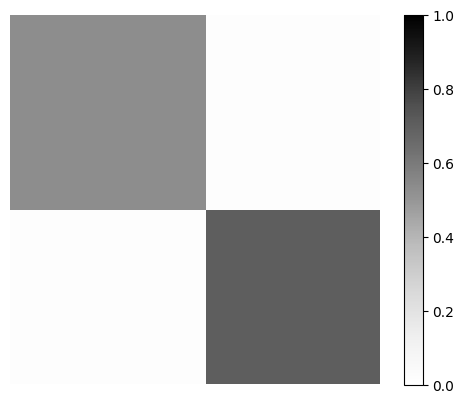

In [38]:
plt.figure()
plt.axis('off')
plt.imshow(w, vmin=0, vmax=1, cmap='Greys')
plt.colorbar()
plt.show()

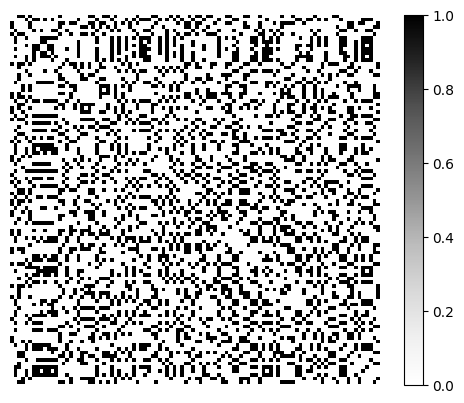

In [39]:
plt.figure()
plt.axis('off')
plt.imshow(adj_2, vmin=0, vmax=1, cmap='Greys')
plt.colorbar()
plt.show()

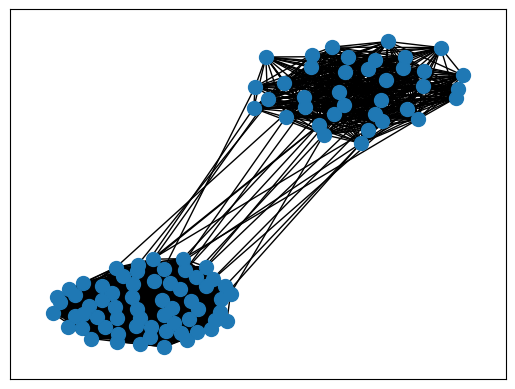

In [13]:
plt.figure()
g = nx.from_numpy_array(adj)
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos, with_labels=False, node_size=100)
plt.show()

# 2) SDE

In [14]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
  
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [15]:
device = 'cpu'

def marginal_prob_std(t, sigma):   
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [16]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [17]:
class Graphons(Dataset):
    def __init__(self, mode='train'):
        self.res = 28
        self.to_tensor = tt.ToTensor()
        
        if mode == 'train':
            self.data = self._generate_data(2_000)
        elif mode == 'val':
            self.data = self._generate_data(200)
        else:
            self.data = self._generate_data(200)
    
    def _generate_data(self, size):
        data = []
        for _ in range(size):
            w = sample_sbm_graphon(
                res=self.res,
                max_groups=2,
                range_p_intra=[0.5, 0.8],
                range_p_inter=[0.1, 0.3],
                range_n_nodes=[10, 100]
            )
            
            # Shuffling everything
            num_rows, num_cols = array.shape

            row_indices = np.arange(self.res)
            np.random.shuffle(row_indices)
            col_indices = np.arange(self.res)
            np.random.shuffle(col_indices)

            w = w[row_indices][:, col_indices]
            data.append(w)
            
        return np.array(data).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.to_tensor(self.data[idx])

In [105]:
train_data = Graphons(mode='train')
val_data = Graphons(mode='val')
test_data = Graphons(mode='test')

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [108]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

In [139]:
n_epochs = 200
batch_size =  32
lr=1e-5

optimizer = torch.optim.Adamax(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in training_loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
num_steps =  500
def Euler_Maruyama_sampler(
    score_model, 
    marginal_prob_std,
    diffusion_coeff, 
    batch_size=64, 
    num_steps=num_steps, 
    device='cuda', 
    eps=1e-3
):
    
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
    return mean_x

In [19]:
signal_to_noise_ratio = 0.16

num_steps =  500
def pc_sampler(
    score_model, 
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64, 
    num_steps=num_steps, 
    snr=signal_to_noise_ratio,                
    device='cuda',
    eps=1e-3
):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)          
    return x_mean

In [20]:
error_tolerance = 1e-5
def ode_sampler(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64, 
    atol=error_tolerance, 
    rtol=error_tolerance, 
    device='cuda', 
    z=None,
    eps=1e-3
):
    t = torch.ones(batch_size, device=device)
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z
    
    shape = init_x.shape

    def score_eval_wrapper(sample, time_steps):
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
        with torch.no_grad():    
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
    def ode_func(t, x):        
        time_steps = np.ones((shape[0],)) * t    
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_31836/3947096710.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


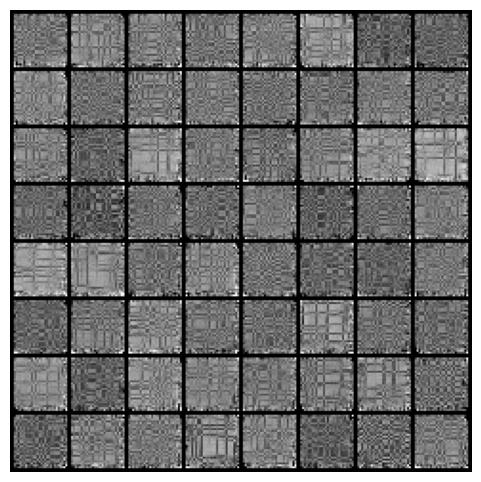

In [97]:
sample_batch_size = 64
sampler = Euler_Maruyama_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_31836/3947096710.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


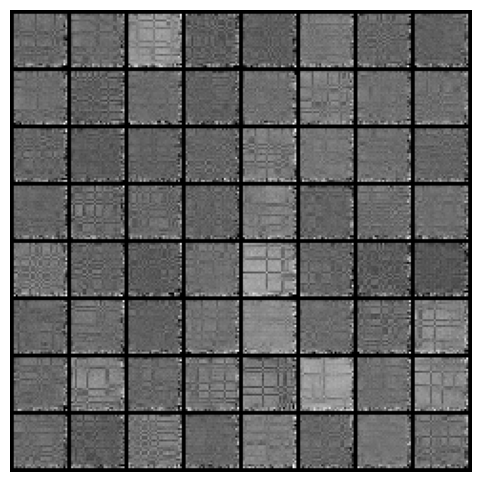

In [132]:
sample_batch_size = 64
sampler = pc_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_31836/3947096710.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 494


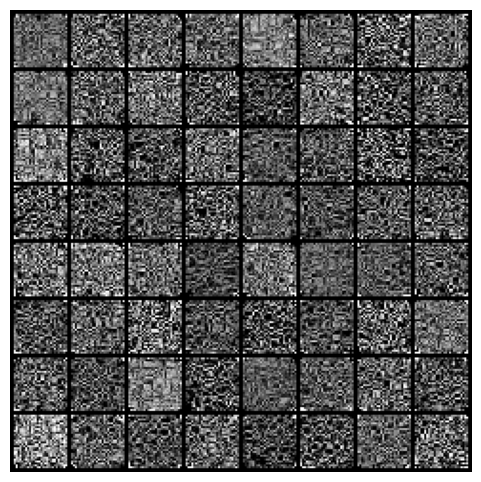

In [86]:
sample_batch_size = 64
sampler = ode_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

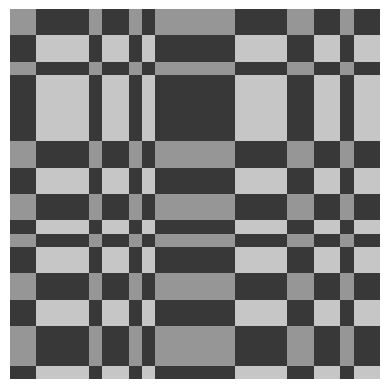

In [133]:
plt.axis('off')
plt.imshow(x[4, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

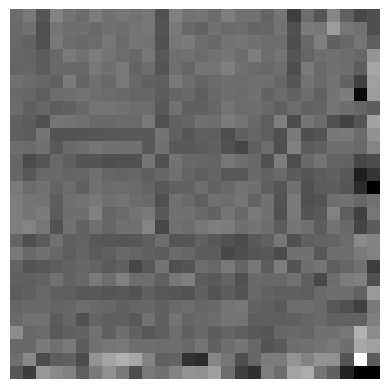

In [134]:
plt.axis('off')
plt.imshow(samples[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

# 3) Increasing levels of complexity

### 3.1) Ordered

In [21]:
class Graphons(Dataset):
    def __init__(self, sort):
        self.res = 100
        self.nodes = 28
        self.to_tensor = tt.ToTensor()
        self.data = self._generate_data(1_000, sort)
    
    def _generate_data(self, size, sort):
        data = []
        for _ in range(size):
            w = sample_sbm_graphon(
                res=self.res,
                max_groups=2,
                range_p_intra=[0.6, 0.8],
                range_p_inter=[0.05, 0.1],
                range_n_nodes=[10, 100]
            )
            adj = get_adj(self.nodes, w, sort=sort)            
            data.append(adj)
        return np.array(data).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.to_tensor(self.data[idx])

In [21]:
data = Graphons(sort=True)
loader = DataLoader(data, batch_size=32, shuffle=True)

In [22]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

In [23]:
n_epochs = 10_000
batch_size =  32
lr=1e-4

losses_0 = []
optimizer = torch.optim.Adamax(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    losses_0.append(avg_loss / num_items)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_74632/3947096710.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


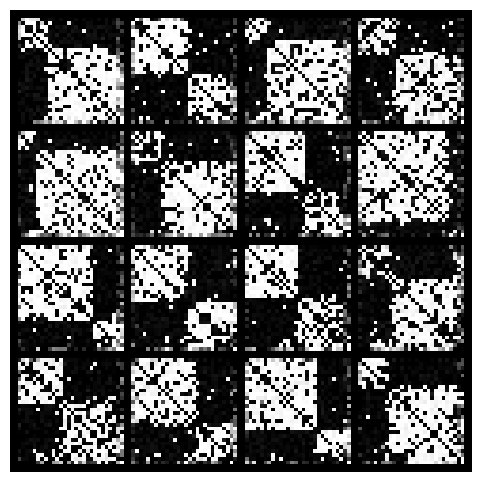

In [24]:
sample_batch_size = 16
sampler = pc_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

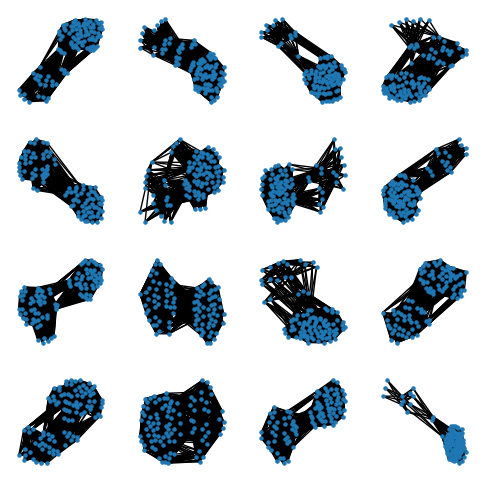

In [25]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, data[i][0], sort=True)
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

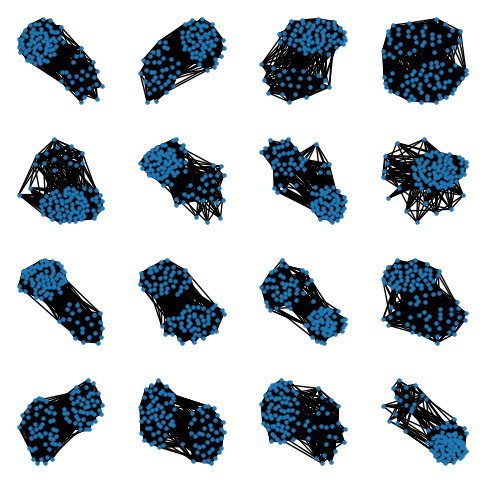

In [26]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, samples[i, 0])
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

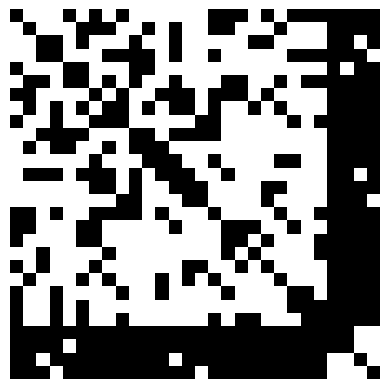

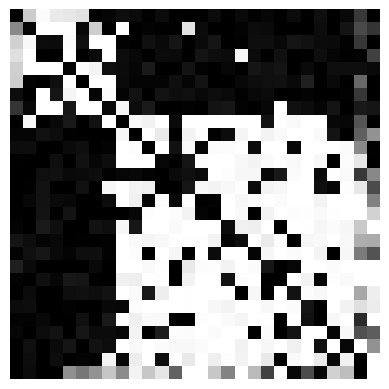

In [27]:
plt.axis('off')
plt.imshow(x[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

plt.axis('off')
plt.imshow(samples[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

### 3.2) Random

In [22]:
data = Graphons(sort=False)
loader = DataLoader(data, batch_size=32, shuffle=True)

In [23]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

In [24]:
n_epochs = 5_000
batch_size =  32
lr=1e-4

losses_1 = []
optimizer = torch.optim.Adamax(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    losses_1.append(avg_loss / num_items)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_86960/3947096710.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


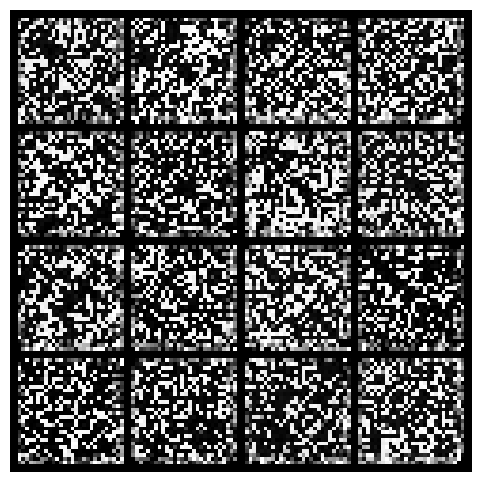

In [25]:
sample_batch_size = 16
sampler = pc_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

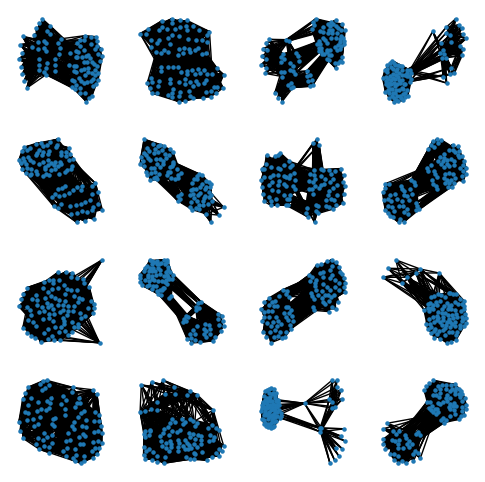

In [26]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, data[i][0], sort=False)
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

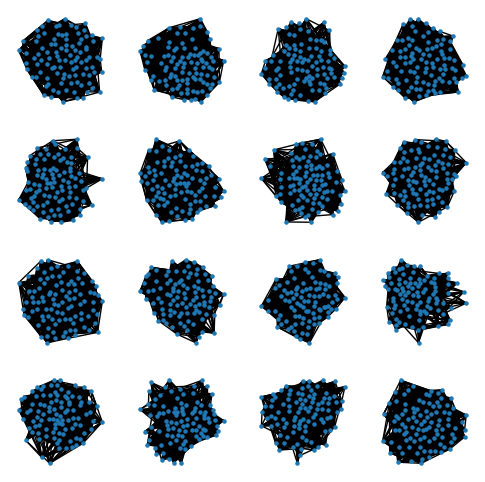

In [27]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, samples[i, 0], sort=False)
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

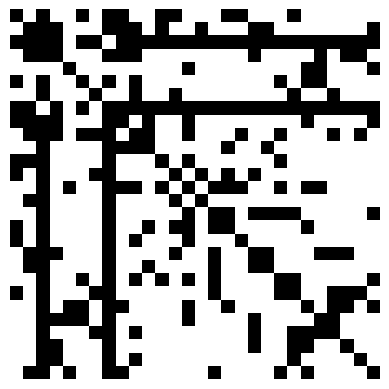

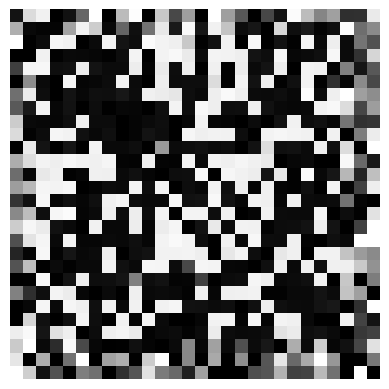

In [28]:
plt.axis('off')
plt.imshow(x[5, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

plt.axis('off')
plt.imshow(samples[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

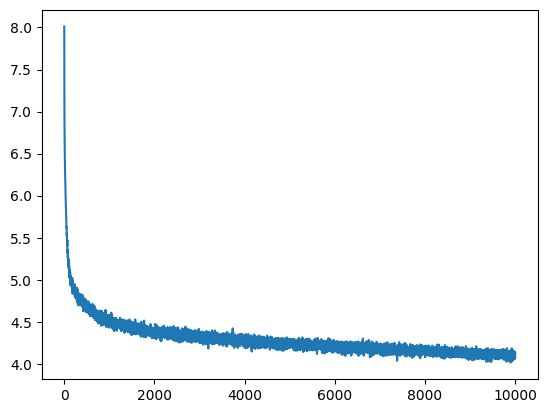

In [28]:
plt.plot(np.log(losses_0))
#plt.plot(np.log(losses_1))
#plt.ylim(0, 200)

(0.0, 200.0)

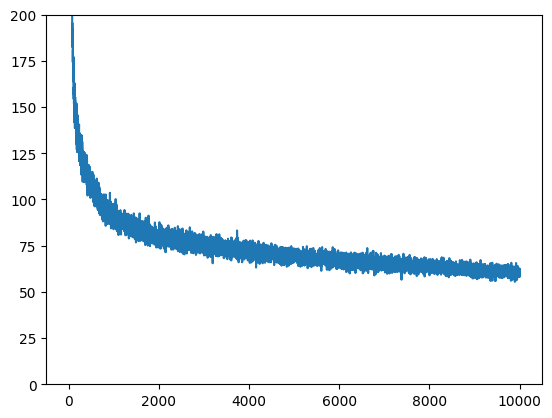

In [29]:
plt.plot(losses_0)
#plt.plot(losses_1)
plt.ylim(0, 200)

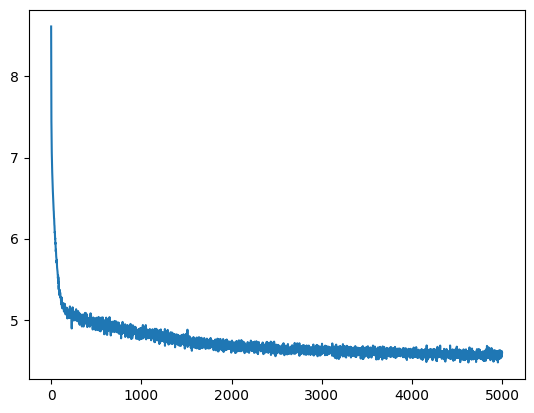

In [29]:
plt.plot(np.log(losses_1))
#plt.ylim(0, 200)

(0.0, 200.0)

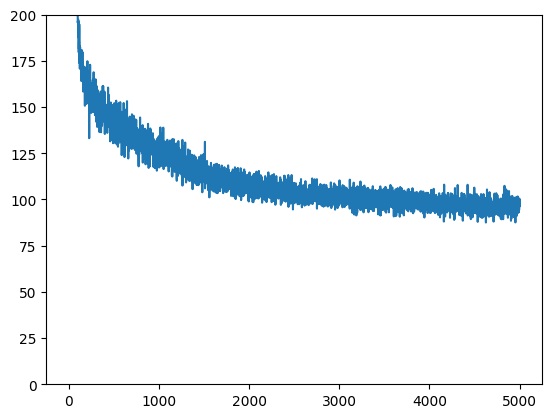

In [30]:
plt.plot(losses_1)
plt.ylim(0, 200)

In [48]:
A = np.random.rand(4, 4)
B = np.random.rand(4, 4)
x = np.random.rand(4)

In [51]:
A @ (- B @ x )

array([-2.76382779, -2.26747552, -3.88669926, -1.78884833])

In [52]:
- (A @ B) @ x

array([-2.76382779, -2.26747552, -3.88669926, -1.78884833])